# Analyzing the UCI Wine Dataset Using Unsupervised Machine Learning

## **1. Clear Objectives and Introduction**
The UCI Wine dataset is a collection of wine data wherein each wine belongs to one of three cultivars in a particular region of Italy. Through this analysis, we aim to leverage unsupervised learning techniques, specifically clustering, to segment the wines into clusters based on their features. Ultimately, we will assess how well these clusters align with the wine cultivars.

### 1.2 Libraries

In [56]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA

# Color palette
wine_palette = sns.color_palette("YlOrRd", n_colors=10)
sns.set_palette(wine_palette)
cmap_wine = 'YlOrRd'

# sklearn warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans", 
            message="The default value of `n_init` will change from 10 to 'auto' in 1.4.")



## **2. Data Loading and Overview**
Using the UCI ML Repository's API, we first fetch the wine dataset. 

In [57]:
# Fetch dataset
wine = fetch_ucirepo(id=109) 

# Data (as pandas dataframes)
X = wine.data.features 
y = wine.data.targets

In [58]:
X.iloc[:5, :7]

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids
0,14.23,1.71,2.43,15.6,127,2.80,3.06
1,13.20,1.78,2.14,11.2,100,2.65,2.76
2,13.16,2.36,2.67,18.6,101,2.80,3.24
3,14.37,1.95,2.50,16.8,113,3.85,3.49
4,13.24,2.59,2.87,21.0,118,2.80,2.69


In [59]:
X.iloc[:5, 7:]

,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,0.28,2.29,5.64,1.04,3.92,1065
1,0.26,1.28,4.38,1.05,3.40,1050
2,0.30,2.81,5.68,1.03,3.17,1185
3,0.24,2.18,7.80,0.86,3.45,1480
4,0.39,1.82,4.32,1.04,2.93,735


In [60]:
y.head()

,class
0,1
1,1
2,1
3,1
4,1


### **2.1 MetaData**
Further details can be seen via metadata and variable information.

## **3. Data Cleaning and Preprocessing**

### 3.1. Check for Missing Values

In [62]:
# Check for missing values
missing_values = X.isnull().sum()
if missing_values.any():
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

### 3.2. Outlier Removal

In [64]:
# Remove Outliers:
z_scores = stats.zscore(X)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X = X[filtered_entries]
y = y[filtered_entries]

### 3.3. Feature Scaling

In [66]:
# Apply Standard Scaler
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled = scaler.fit_transform(X_scaled)

## **4. Exploratory Data Analysis (EDA)**
### 4.1. Target Distribution

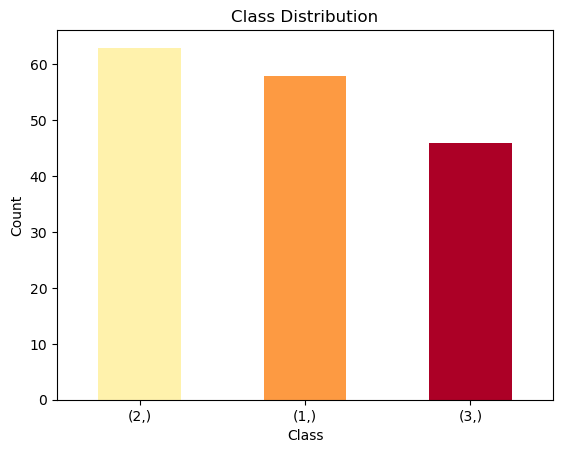

In [68]:
# Get value counts
value_counts = y.value_counts()

# Plotting
bar_colors = [wine_palette[0], wine_palette[4], wine_palette[9]]
value_counts.plot(kind='bar' ,color=bar_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=0)
plt.show()

### 4.2. Correlation Matrix

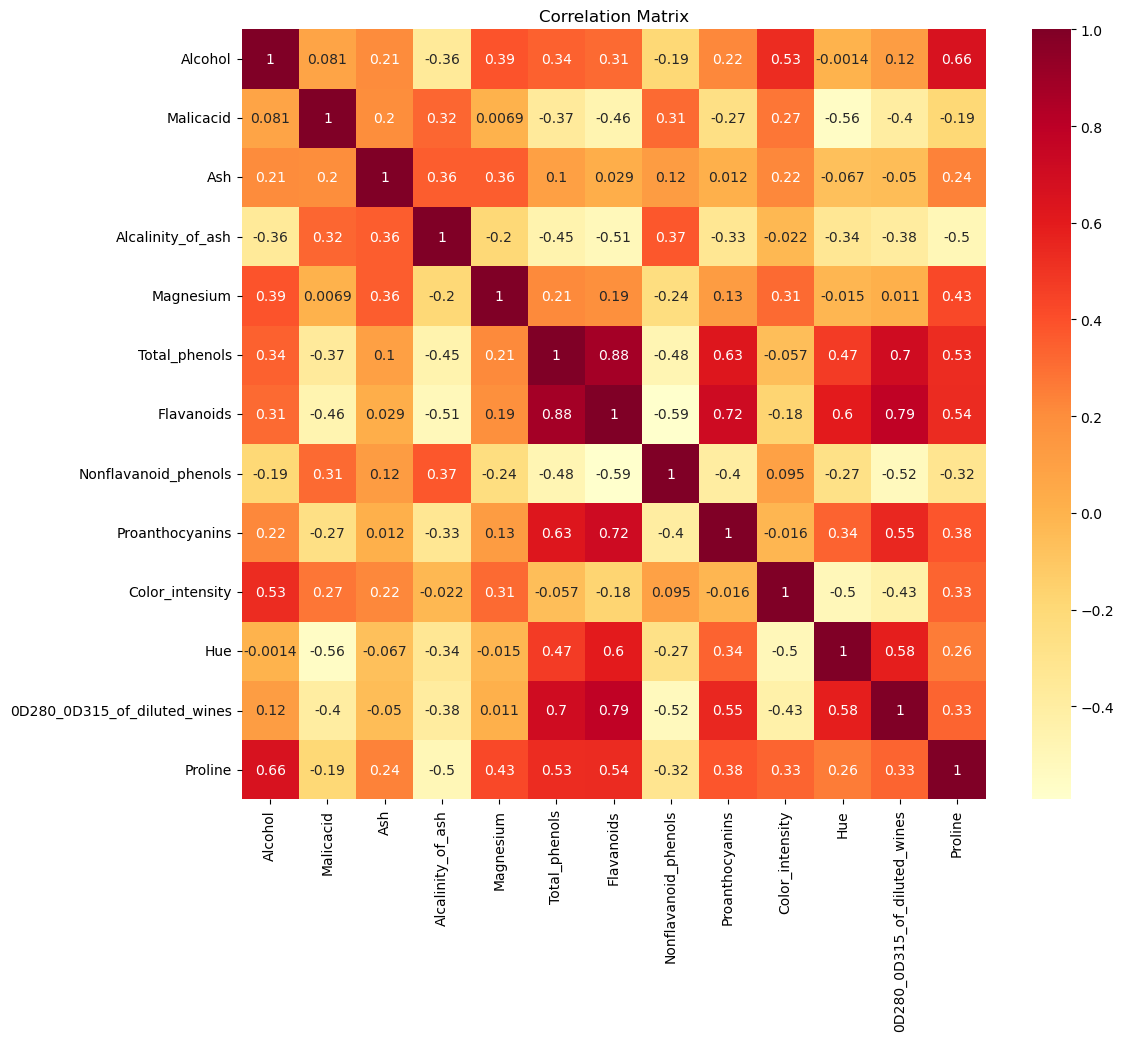

In [70]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap=cmap_wine)
plt.title("Correlation Matrix")
plt.show()

### 4.3. Distribution of Features

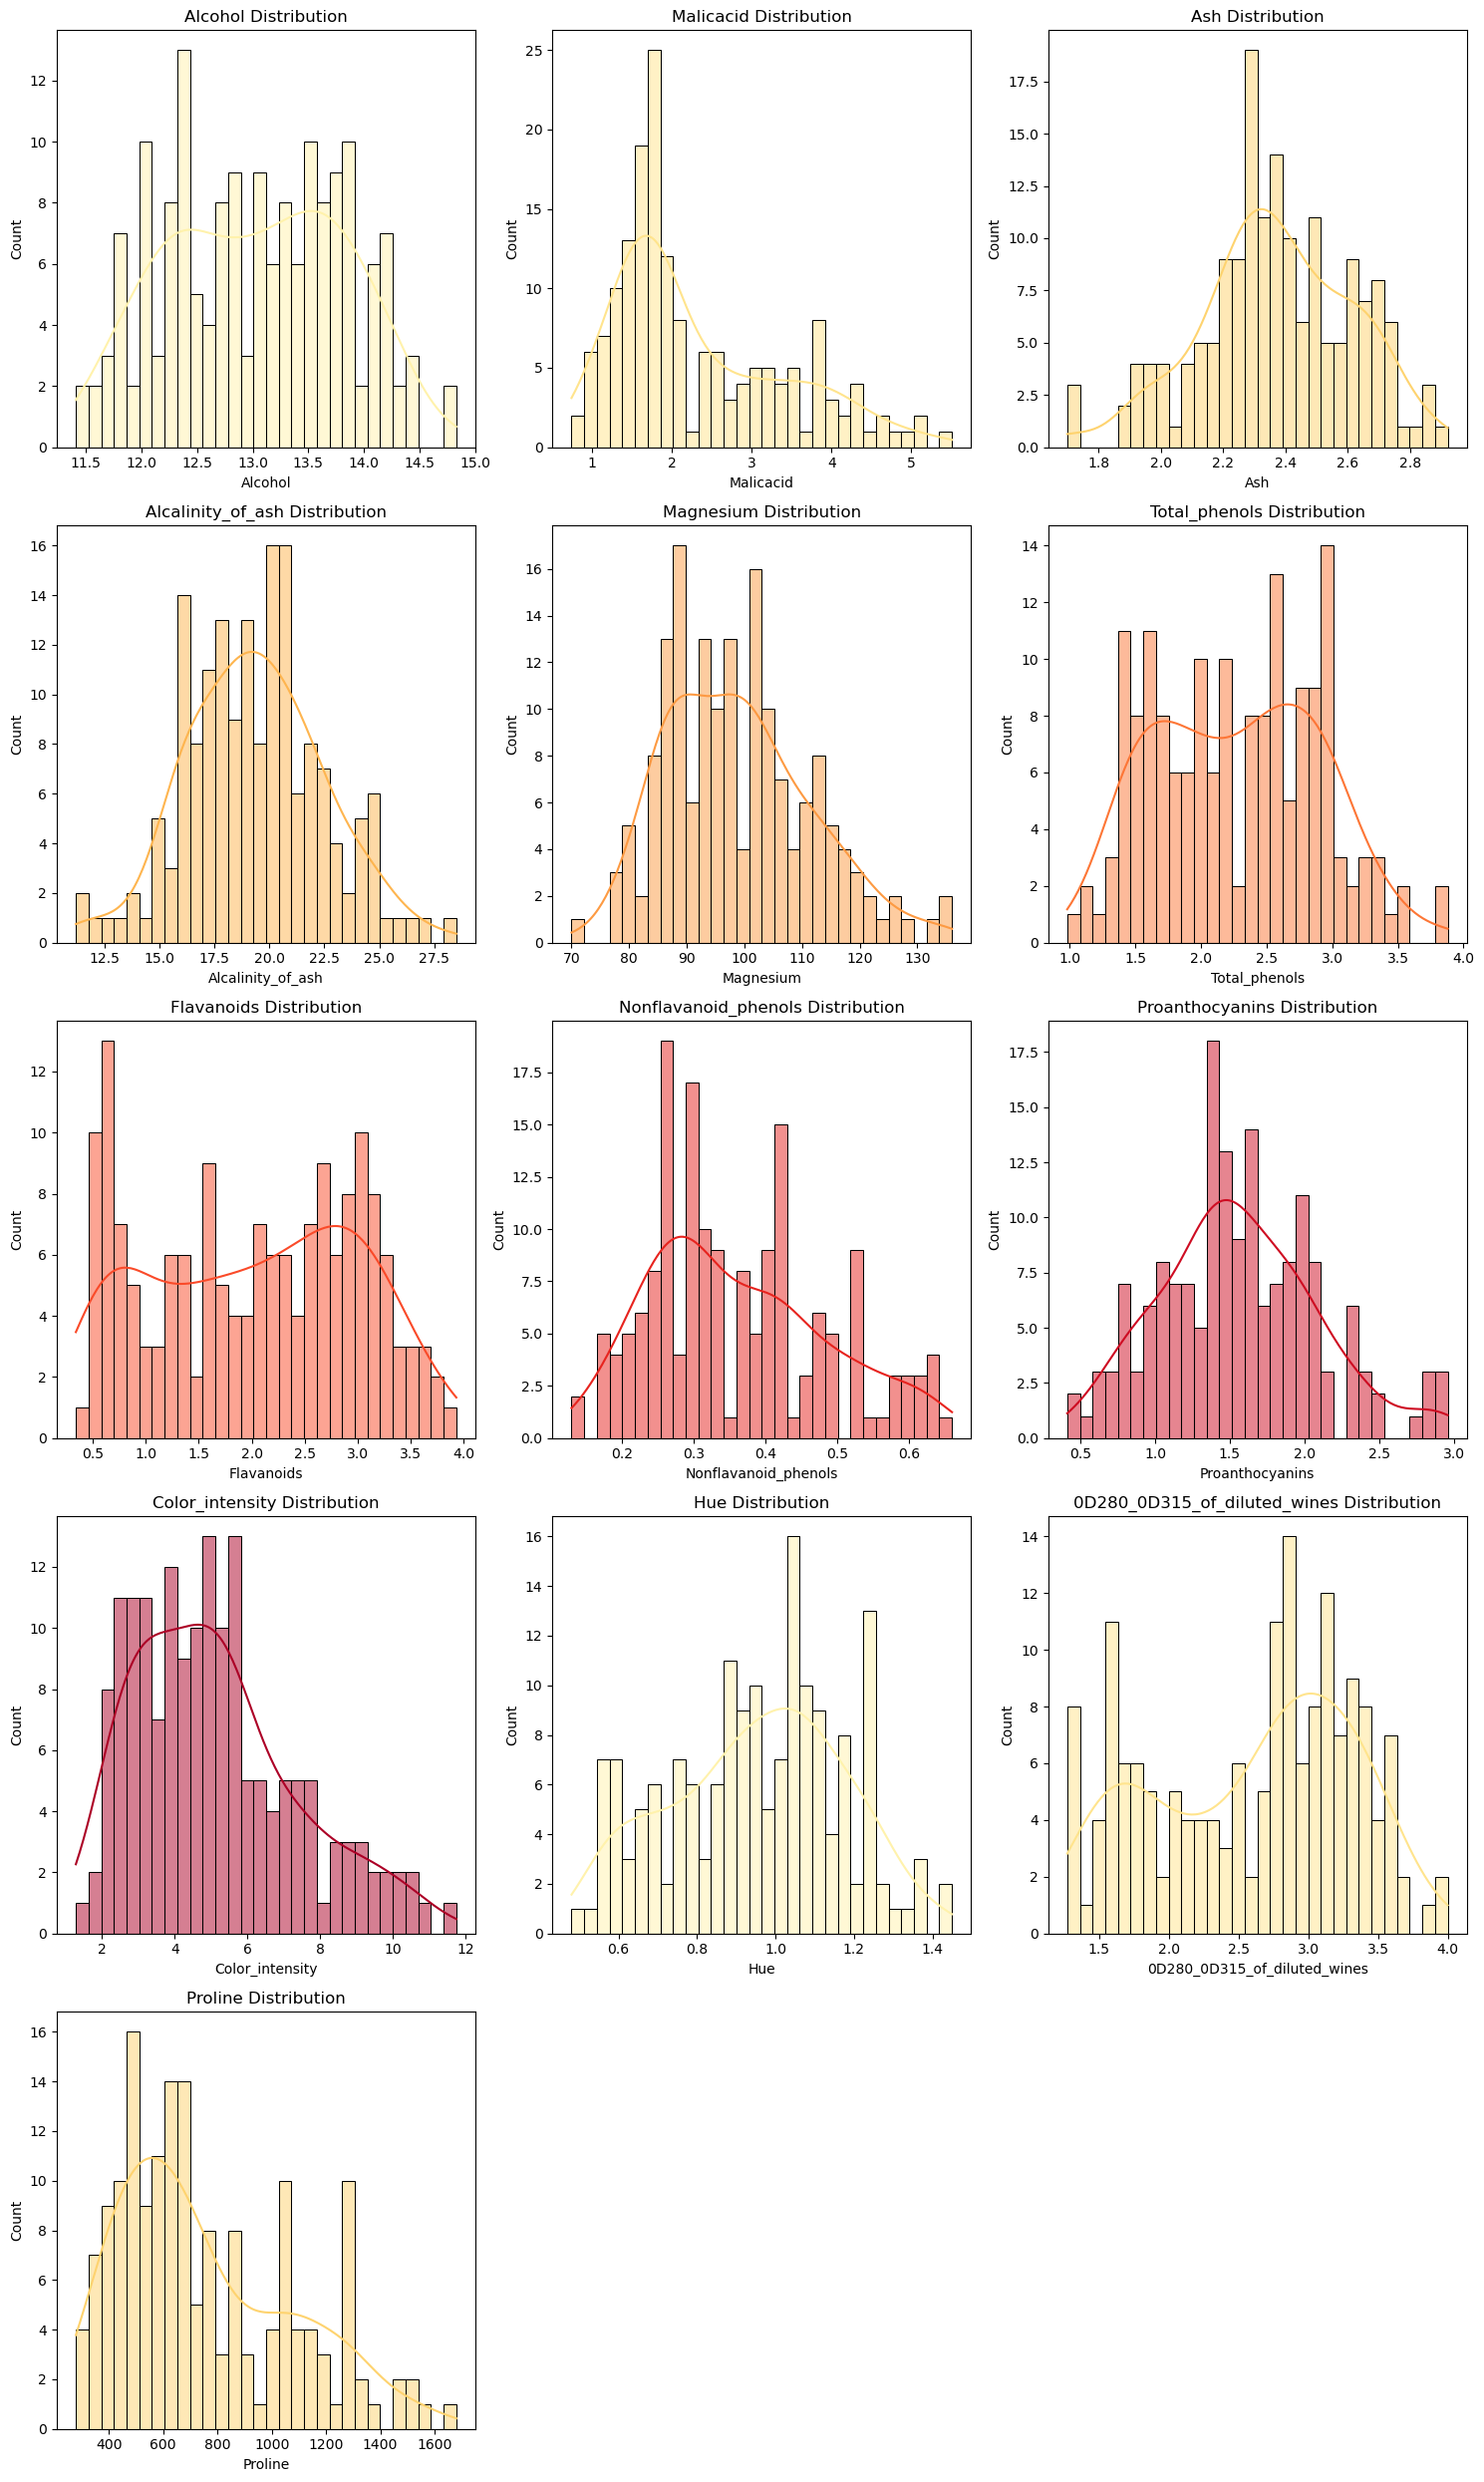

In [72]:
# Distributions
plots_per_row = 3
n_cols = len(X.columns)
n_rows = int(np.ceil(n_cols / plots_per_row))
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(15, 5*n_rows))
axes = axes.ravel()
for i, column in enumerate(X.columns):
    sns.histplot(X[column], kde=True, bins=30, ax=axes[i], color=wine_palette[i % len(wine_palette)])
    axes[i].set_title(f"{column} Distribution")
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

### 4.4. Outlier Detection

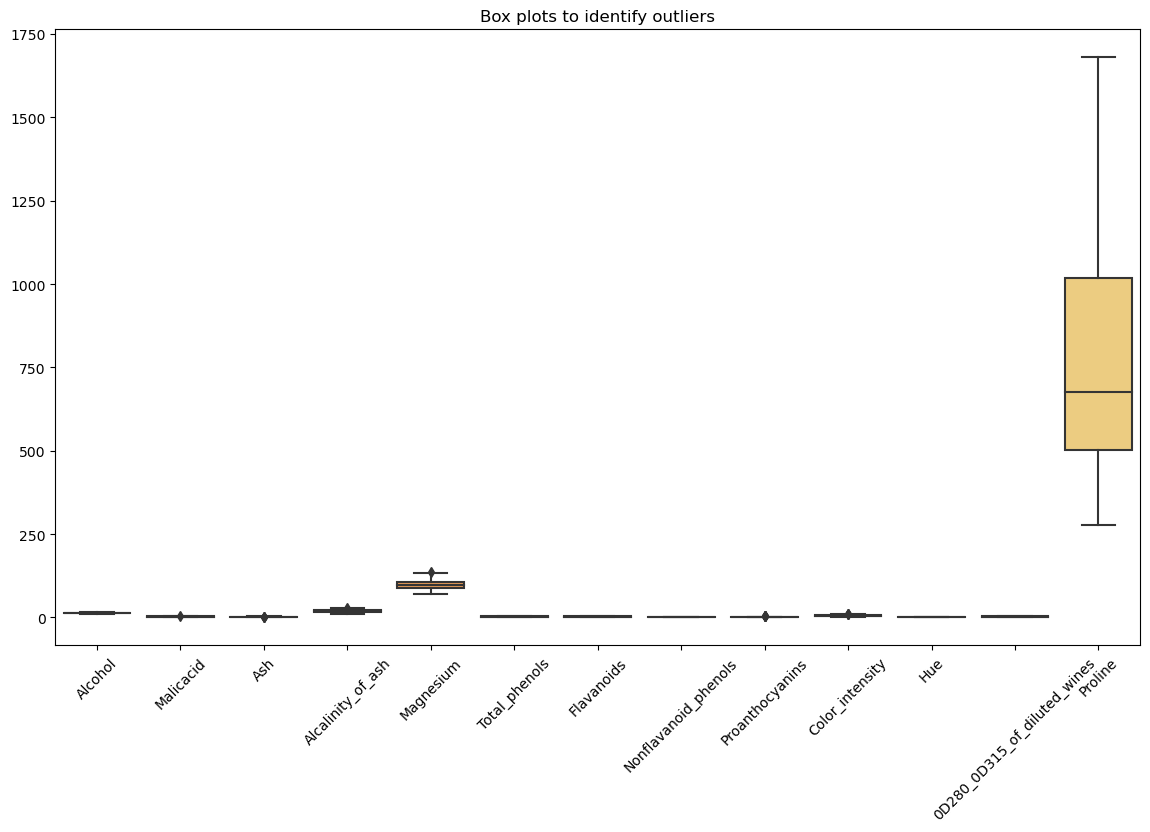

In [43]:
# Checking outliers
plt.figure(figsize=(14, 8))
sns.boxplot(data=X, palette=wine_palette)
plt.xticks(rotation=45)
plt.title("Box plots to identify outliers")
plt.show()

## **5. Modeling**

### 5.1. Clustering using KMeans

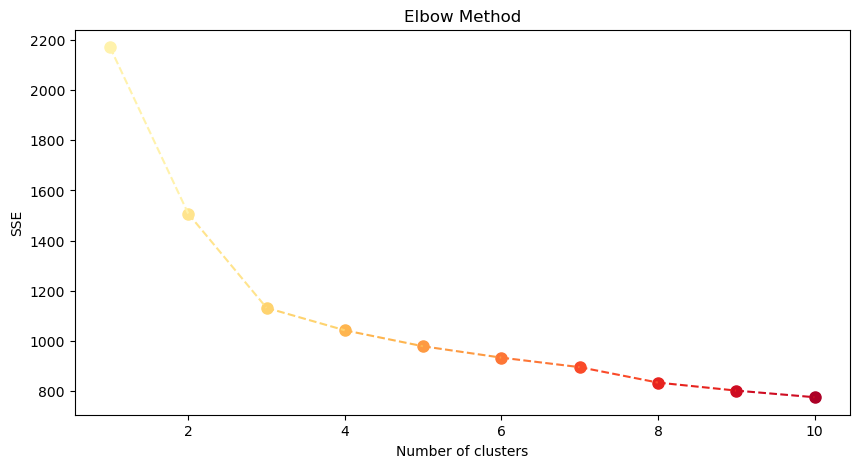

Silhouette Score: 0.2973
Adjusted Rand Score: 0.9294


In [78]:
# KMeans Clustering
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=123).fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
for idx, value in enumerate(sse):
    plt.plot(idx + 1, value, 'o', color=wine_palette[idx], markersize=8)
for i in range(1, len(sse)):
    plt.plot([i, i+1], [sse[i-1], sse[i]], color=wine_palette[i-1], linestyle='--')

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=123).fit(X_scaled)
cluster_labels = kmeans.predict(X_scaled)
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# If you have true labels, compute Adjusted Rand Score
ars = adjusted_rand_score(y['class'], cluster_labels)
print(f"Adjusted Rand Score: {ars:.4f}")

### 5.2. Visualizing with PCA

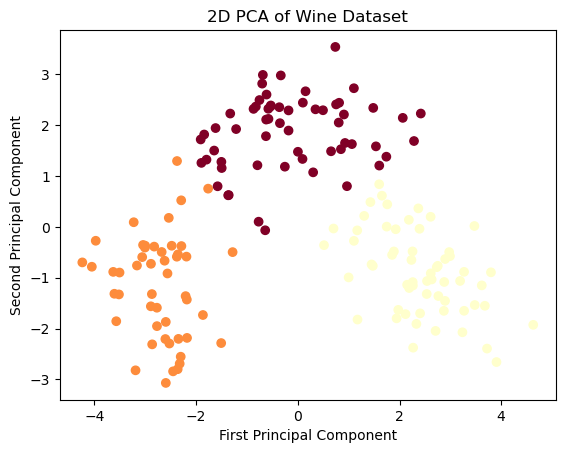

In [47]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap=cmap_wine)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D PCA of Wine Dataset')
plt.show()

In [48]:
# 5.2. Visualizing with PCA discussion
# 1. Amount of variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by first principal component: {explained_variance[0]*100:.2f}%")
print(f"Variance explained by second principal component: {explained_variance[1]*100:.2f}%")

# 2. Cumulative variance explained by the principal components used
cumulative_variance = explained_variance.cumsum()
print(f"Cumulative variance explained by two principal components: {cumulative_variance[1]*100:.2f}%")

# 3. Loadings (or weights) of the original features on each principal component
loadings = pca.components_
print("\nLoadings of original features on principal components:")
for i, component in enumerate(loadings):
    print(f"Component {i+1}:")
    for j, weight in enumerate(component):
        print(f"Feature {j+1}: {weight:.4f}")


Variance explained by first principal component: 38.70%
Variance explained by second principal component: 20.03%
Cumulative variance explained by two principal components: 58.73%

Loadings of original features on principal components:
Component 1:
Feature 1: 0.1775
Feature 2: -0.2410
Feature 3: -0.0082
Feature 4: -0.2846
Feature 5: 0.1232
Feature 6: 0.3867
Feature 7: 0.4207
Feature 8: -0.2911
Feature 9: 0.3181
Feature 10: -0.0653
Feature 11: 0.2898
Feature 12: 0.3596
Feature 13: 0.2902
Component 2:
Feature 1: -0.4534
Feature 2: -0.2439
Feature 3: -0.3060
Feature 4: 0.0432
Feature 5: -0.3771
Feature 6: -0.0384
Feature 7: 0.0312
Feature 8: -0.0162
Feature 9: -0.0148
Feature 10: -0.5169
Feature 11: 0.2691
Feature 12: 0.1891
Feature 13: -0.3448


## **6. Evaluation and Validation**
We'll use Adjusted Rand Score to evaluate the clustering. This score measures the similarity between true labels and predicted labels, adjusted for chance.

The primary objective of clustering in unsupervised machine learning is to segment data into meaningful groups. However, in our unique case with the UCI Wine dataset, we have the benefit of ground truth labels for comparison. This allows us to validate the performance of our clustering algorithm against the true labels, though it's essential to note that in a traditional unsupervised scenario, this comparison might not be possible.

#### 6.1. Adjusted Rand Score (ARI)

We've already calculated the ARI:

In [49]:
print(f"Adjusted Rand Score: {ari}")

Adjusted Rand Score: 0.9293826065878132


The ARI is a measure that computes the similarity between the true labels and the ones predicted by our clustering algorithm, adjusting for chance. An ARI score of 1.0 indicates that the clusterings are identical, while a score of 0 suggests the clustering is random.

Given our ARI score of approximately `0.93`, our KMeans clustering has performed exceptionally well in segmenting the wine data, aligning very closely with the actual cultivar groupings.

#### 6.2. Visual Inspection with PCA
PCA visualization provides a clear visual indication of how well our clusters have been formed. If clusters are distinctly separate in the PCA plot, it suggests a good clustering pattern.

From our PCA plot:`

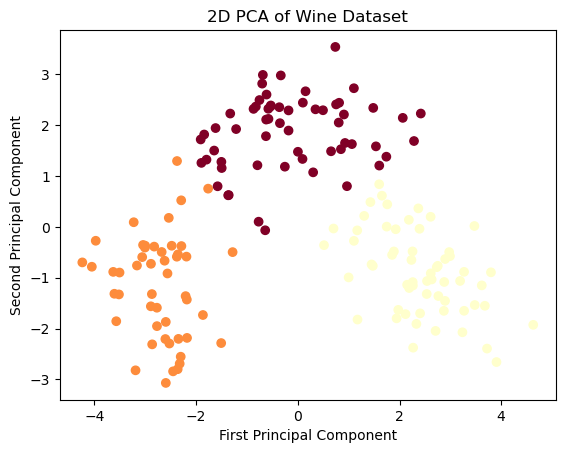

In [50]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap=cmap_wine)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D PCA of Wine Dataset')
plt.show()

We should visually inspect if the datapoints are forming clear and distinct clusters. Overlapping clusters indicate potential misclassifications.

## **7. Conclusions and Future Work**
- Through comprehensive analysis of the UCI Wine dataset, rigorous data cleaning and detailed exploration of wine attributes like Proline and Malic Acid have emerged as potential key differentiators, setting a solid foundation for predictive modeling.
- The KMeans clustering, guided by the Elbow Method, demonstrated the significance of choosing the right cluster count, with metrics like Silhouette Score and Adjusted Rand Score affirming our model's effectiveness.
- Venturing into unsupervised learning for wine cultivar prediction underscores the importance of deeply understanding data nuances, showcasing the potential to uncover inherent wine groupings and enriching our knowledge of wines from a specific Italian region.